In [1]:
import csv

annotation_list = ["Tweet Annotations - Feb Translated Annotations.tsv"]
annotation_list.append("Tweet Annotations - Mar Translated Annotations.tsv")
annotation_list.append("Tweet Annotations - Apr Translated Annotations.tsv")

In [2]:
# Transfer the contents of a tsv file to a list for easier access
def tsv_to_list(annotation_file):
    annotation_list = []
    annotation = open(annotation_file, encoding='utf-8')
    read_tsv = csv.reader(annotation, delimiter="\t") 
    for row in read_tsv:
        annotation_list.append(row)
    return annotation_list

In [33]:
# Get the label for each verse for one annotator
# N: -1, N+NU: -0.5, NU: 0, P+NU: 0.5, P: 1
def get_labels_for(annotation):
    tweets_and_labels = []
    row_num = 0
    for row in annotation:
        if row_num == 0:
            row_num += 1
            continue
        if row[15] != '': # don't use unsure
            row_num += 1
            continue
            #print("not using unsure row", row_num+1)
        if 'UNUSABLE' in row[16].upper() or 'NOT ENOUGH INFO' in row[16].upper():
            row_num += 1
            continue
            #print("unusable row", row_num+1)
        elif row[6].upper() == 'X' and (row[8].upper() != 'X' and row[7].upper() == 'X'): # don't use pos + neg mixed labels
            row_num += 1
            continue
            #print("not using pos+neg row", row_num+1)
        elif row[6].upper() == 'X' and (row[7].upper() != 'X' and row[8].upper() != 'X'): # only pos
            new_row = [annotation[row_num][0], annotation[row_num][1], annotation[row_num][2], annotation[row_num][3], annotation[row_num][4], annotation[row_num][5], 2]
            tweets_and_labels.append(new_row)
        #elif row[6].upper() == 'X' and (row[8].upper() == 'X' and row[7].upper() != 'X'): # pos + neu
        #    new_row = [annotation[row_num][0], annotation[row_num][1], annotation[row_num][2], annotation[row_num][3], annotation[row_num][4], annotation[row_num][5], 3]
        #    tweets_and_labels.append(new_row)
        elif row[8].upper() == 'X' and (row[6].upper() != 'X' and row[7].upper() != 'X'): # only neu 
            new_row = [annotation[row_num][0], annotation[row_num][1], annotation[row_num][2], annotation[row_num][3], annotation[row_num][4], annotation[row_num][5], 1]
            tweets_and_labels.append(new_row)
        elif row[7].upper() == 'X' and (row[8].upper() != 'X' and row[6].upper() != 'X'): # only neg
            new_row = [annotation[row_num][0], annotation[row_num][1], annotation[row_num][2], annotation[row_num][3], annotation[row_num][4], annotation[row_num][5], 0]
            tweets_and_labels.append(new_row)
        #elif row[8].upper() == 'X' and (row[7].upper() == 'X' and row[6].upper() != 'X'): # neg + neu
        #    new_row = [annotation[row_num][0], annotation[row_num][1], annotation[row_num][2], annotation[row_num][3], annotation[row_num][4], annotation[row_num][5], 2]
        #    tweets_and_labels.append(new_row) 
        #else:
        #    print("outlier row:", row_num+1)
        row_num += 1
    return tweets_and_labels

In [34]:
feb_list = tsv_to_list(annotation_list[0])
feb_labels = get_labels_for(feb_list)
mar_list = tsv_to_list(annotation_list[1])
mar_labels = get_labels_for(mar_list)
apr_list = tsv_to_list(annotation_list[2])
apr_labels = get_labels_for(apr_list)

all_labels = feb_labels + mar_labels + apr_labels
#print(all_labels.count(-1), all_labels.count(0), all_labels.count(1))

import pandas as pd
df = pd.DataFrame(all_labels, columns=['tweetID', 'tweetTime', 'tweetText', 'tweetLang', 'tweetCoordinates', 'tweetPlace', 'tweetSentiment'])
df.head()


,tweetID,tweetTime,tweetText,tweetLang,tweetCoordinates,tweetPlace,tweetSentiment
0,1232073974093352966,2020-02-24 22:45:00,I love to look at people's opinions about the ...,es,,,2
1,1223738854596927488,2020-02-01 22:44:13,The latest The AmericanAwaken ing Daily PM! T...,en,,,0
2,1224564516748283904,2020-02-04 5:25:06,#Macau casinos will be closed for half a month...,en,,,0
3,1232651956528799747,2020-02-26 13:01:42,Social media conspiracies blame coronavirus on...,ca,,,0
4,1231469470020972545,2020-02-23 6:42:55,"Coronavirus, official: patient zero has nothin...",it,,,1


In [5]:
import pandas as pd
import numpy as np
!pip3 install tensorflow
!pip3 show tensorflow
!pip3 install keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras import optimizers

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\steffi\appdata\local\programs\python\python38\lib\site-packages
Requires: grpcio, tensorboard, termcolor, keras-preprocessing, opt-einsum, google-pasta, numpy, wrapt, six, scipy, absl-py, h5py, protobuf, wheel, tensorflow-estimator, astunparse, gast
Required-by: 


In [26]:
!pip3 install nltk
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s


  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=a98f54150389291c50df095889b7dfa8773f1f771b83be3763c891d08da36a76
  Stored in directory: c:\users\steffi\appdata\local\pip\cache\wheels\ff\d5\7b\f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steffi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [35]:
import re
X = df['tweetText'].values
X= X.astype(str)
y = df['tweetSentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = np.array([text_preprocessing(text) for text in X_train])
X_test = np.array([text_preprocessing(text) for text in X_test])

In [36]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

num_words=9000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 278
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [37]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix
    
embedding_dim = 300
embedding_matrix = create_embedding_matrix('glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))


embedding accuracy: 0.8438124861141968


In [38]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
opt = optimizers.Adam(lr=0.0002)
model.compile(optimizer=opt, loss='binary_crossentropy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 278, 300)          2700600   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 276, 256)          230656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 276, 256)          0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,931,513
Trainable params: 2,931,513
Non-trainable params: 0
_________________________________________________________________


In [39]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
res = model.fit(X_train, y_train, epochs=15, verbose=True, callbacks=callbacks, validation_data=(X_test, y_test), batch_size=100)

y_pred = model.predict(X_test)

Epoch 1/15
34/34 [==============================] - 12s 347ms/step - loss: 0.6384 - val_loss: 0.5581
Epoch 2/15
34/34 [==============================] - 13s 374ms/step - loss: 0.4303 - val_loss: 0.4712
Epoch 3/15
34/34 [==============================] - 14s 402ms/step - loss: 0.2886 - val_loss: 0.3989
Epoch 4/15
34/34 [==============================] - 13s 397ms/step - loss: 0.1673 - val_loss: 0.3384
Epoch 5/15
34/34 [==============================] - 14s 414ms/step - loss: 0.0430 - val_loss: 0.2798
Epoch 6/15
34/34 [==============================] - 15s 431ms/step - loss: -0.0791 - val_loss: 0.2331
Epoch 7/15
34/34 [==============================] - 15s 447ms/step - loss: -0.2167 - val_loss: 0.1780
Epoch 8/15
34/34 [==============================] - 14s 412ms/step - loss: -0.3633 - val_loss: 0.1300
Epoch 9/15
34/34 [==============================] - 14s 399ms/step - loss: -0.5361 - val_loss: 0.0744
Epoch 10/15
34/34 [==============================] - 14s 400ms/step - loss: -0.7191 - v

In [40]:
thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
   
    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))

Threshold: 0.1000, Precision: 0.3684, Recall: 0.4186, F1-measure: 0.3115
Threshold: 0.2000, Precision: 0.3650, Recall: 0.4249, F1-measure: 0.3253
Threshold: 0.2500, Precision: 0.3620, Recall: 0.4234, F1-measure: 0.3271
Threshold: 0.3000, Precision: 0.3638, Recall: 0.4290, F1-measure: 0.3347
Threshold: 0.4000, Precision: 0.3657, Recall: 0.4367, F1-measure: 0.3457
Threshold: 0.5000, Precision: 0.3654, Recall: 0.4425, F1-measure: 0.3540
Threshold: 0.6000, Precision: 0.3641, Recall: 0.4437, F1-measure: 0.3582
Threshold: 0.7000, Precision: 0.3642, Recall: 0.4462, F1-measure: 0.3637
Threshold: 0.8000, Precision: 0.3577, Recall: 0.4377, F1-measure: 0.3626
Threshold: 0.9000, Precision: 0.3506, Recall: 0.4325, F1-measure: 0.3692


c:\users\steffi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
column_names = ['neg', 'neu', 'pos']
f1_scores = []
threshold = 0.7
for i in range(0,3):
    emotion_prediction = y_pred #[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_test #[:,i]
    precision = precision_score(emotion_test, emotion_prediction, average='weighted')
    recall = recall_score(emotion_test, emotion_prediction, average='weighted')
    f1 = f1_score(emotion_test, emotion_prediction, average='weighted')
    f1_scores.append(f1)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))

Emotion: neg, Precision: 0.5444, Recall: 0.4450, F1-measure: 0.4319
Emotion: neu, Precision: 0.5444, Recall: 0.4450, F1-measure: 0.4319
Emotion: pos, Precision: 0.5444, Recall: 0.4450, F1-measure: 0.4319


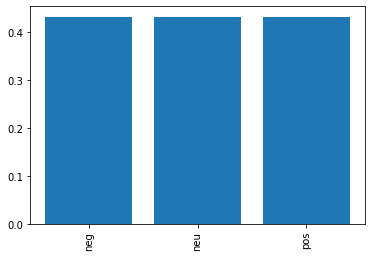

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(column_names,f1_scores)
plt.xticks(rotation=90)
plt.show()